# Getting started

In [46]:
import pandas as pd
import sklearn
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import emoji

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

from nltk.stem import WordNetLemmatizer

seed = 77

In [47]:
main_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [48]:
main_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [49]:
# nltk.download('omw-1.4')

In [50]:
main_df.drop(columns=['id'], inplace = True)

# EDA

In [51]:
main_df.shape

(7613, 4)

In [52]:
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [53]:
main_df.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [54]:
len(set(main_df['location'])) # i think location feature should be dropped

3342

In [55]:
main_df.drop(columns=['location'], inplace=True)
test_df.drop(columns=['location'], inplace=True)

In [56]:
train_data, valid_data, train_target, valid_target = train_test_split(main_df.drop(columns = ["target"]), 
                                                                      main_df['target'],  
                                                                      stratify=main_df['target'],
                                                                      test_size=0.2,
                                                                      random_state=seed)

In [57]:
x = set(train_data['keyword'])
len(x)

222

In [58]:
def fillna(df, col, replace_val='no_keyword') -> None:
    # replace_val = df[col].value_counts().index[0]
    df[col].fillna(replace_val, inplace=True)
    
fillna(train_data, 'keyword')
fillna(valid_data, 'keyword')
fillna(test_df, 'keyword')

# fillna(train_data, 'location', 'no_loc_mentioned')
# fillna(valid_data, 'location', 'no_loc_mentioned')
# fillna(test_df, 'location', 'no_loc_mentioned')

In [59]:
def remove_invalid_data(df: pd.DataFrame, col:str) -> None:
    df[col] = df[col].apply(lambda x: x.replace(r'%20',' '))
    
remove_invalid_data(train_data, 'keyword')
remove_invalid_data(valid_data, 'keyword')
remove_invalid_data(test_df, 'keyword')

In [60]:
lemmatizer = WordNetLemmatizer()

for df in [train_data, valid_data, test_df]:
    df['keyword'] = df['keyword'].apply(lambda x: " ".join(lemmatizer.lemmatize(w) for w in x.split(" ")))

In [61]:
x = set(train_data['keyword'])
len(x)

212

In [62]:
# %20 is a code for space button
for i in x:
    print(i)

weapon
devastated
suicide bomber
hostage
emergency service
mass murder
hazard
collapsed
explosion
upheaval
evacuated
injury
no_keyword
blizzard
explode
detonation
mayhem
ruin
trauma
earthquake
seismic
bombed
derailed
hellfire
catastrophe
wildfire
terrorist
collided
engulfed
fear
battle
hailstorm
nuclear reactor
building on fire
body bagging
bleeding
blew up
obliteration
inundated
lava
exploded
rescue
police
wreck
demolition
fire truck
collision
derail
derailment
building burning
panicking
rioting
crush
aftershock
drown
desolate
fatality
demolished
military
disaster
destruction
drowning
war zone
devastation
quarantined
avalanche
crash
flooding
apocalypse
wrecked
sinkhole
windstorm
dead
nuclear disaster
flood
accident
heat wave
collapse
hijacker
annihilation
annihilated
smoke
injured
rescued
scream
terrorism
blazing
burning building
bombing
cyclone
riot
armageddon
eyewitness
bridge collapse
damage
obliterated
casualty
threat
collide
destroy
rubble
outbreak
violent storm
desolation
airpla

In [63]:
for i in range(10):
    print(train_data['text'].values[i])
    print()

@YoungHeroesID LAVA BLAST dan POWER RED #PantherAttack @Mirmanda11 @evaaaSR

Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/wGWiQmICL1

@kynespeace *blight

Read a SchoolboyÛªs Eyewitness Account of Hiroshima http://t.co/pq0D7MH3qr

Hey girl you must be Toe Hobbit: Part Two: ghe Desolation of Smaug because I'm not interested in seeing you. Sorry.

SEISMIC RISK: a COMPARISON between 2 case studies: CALABRIA AND MALTA http://t.co/HmRtqEykyI

((OFFICIAL VID)) #DoubleCups &gt;&gt; https://t.co/lfKMTZaEkk &gt;&gt; @TrubGME Prod @THISIZBWRIGHT &gt;&gt; #ARMAGEDDON

*CUE THE JARIANA STANS SCREAMING

Niggas favorite question is why you single ?? bitch I don't know pussy too wet almost drowned a nigga ??????????

Still no plans? Don't worry we got you covered. Plenty of Seismic IPA and Seismic Squeeze Radler to help... http://t.co/A8nMdkd3rV



In [64]:
train_data['text'].values[6]

'((OFFICIAL VID)) #DoubleCups &gt;&gt; https://t.co/lfKMTZaEkk &gt;&gt; @TrubGME Prod @THISIZBWRIGHT &gt;&gt; #ARMAGEDDON'

In [70]:
nltk.tokenize.word_tokenize(train_data['text'].values[3])

['Read', 'a', 'Schoolboy\x89Ûªs', 'Eyewitness', 'Account', 'of', 'Hiroshima']

# Feature engineering

In [66]:
def add_features(df: pd.DataFrame):
    df['text_count_chars'] = df['text'].apply(lambda x: len(x))
    df['text_count_words'] = df['text'].apply(lambda x: len(x.split(" ")))
    df['text_count_@'] = df['text'].apply(lambda x: x.count(r"@"))
    df['text_count_http'] = df['text'].apply(lambda x: x.count(r"http"))
    df['text_count_hashtag'] = df['text'].apply(lambda x: x.count(r"#"))
    
add_features(train_data)
add_features(valid_data)
add_features(test_df)

In [67]:
def clean_tweet(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    return tweet

In [68]:
#clean text
for df in [train_data, valid_data, test_df]:
    df['text'] = df['text'].apply(lambda x: clean_tweet(x))

In [71]:
for i in range(10,20):
    print(train_data['text'].values[i])
    print()

I know it's a question of interpretation but this is a sign of the apocalypse. I called it

It's been 70 years (and one hour) since the bombing of Hiroshima. Let's take this time to remember.

For the people who died in Human Experiments by Unit 731 of Japanese military

Womens Buckle Casual Stylish Shoulder Handbags Pockets Cross Body Bags Green

Romantic dramatic but never panic original sensei write rhymes in the attic

I don't laugh out loud at many things. But man I really lol @ the big bang theory.

Marquei como visto Dragon Ball Super - 1x1 - The God of Destruction\'s Dream bancodeseries

Deal of The Day : Brand New DSERIALPCILP Lava Computer PCI Bus Dual Serial 16550 Board eÛ 

If a nigga was a threat then that boy ah be thru ????

13000 evacuated as California firefighters fight flames to save homes. RockyFire



# Train model

In [72]:
def tokenize_text(txt, min_token_size=3):
    lemmatizer = WordNetLemmatizer() # lemmatizer.lemmatize
    #stopwrods = set(nltk.corpus.stopwords.words('english')) #sno.stem
    sno = nltk.stem.SnowballStemmer('english')
    punctuations = set(["...",":","-",".","?","@","*",";","*",'&',"gt","-",
                       "\x89Ûªs"])
    all_tokens = nltk.tokenize.word_tokenize(txt)
    return [sno.stem(token) for token in all_tokens if (len(token)> min_token_size and token not in punctuations)]

In [73]:
MAX_DF = 0.9
MIN_DF = 5

linear_model = LogisticRegression(penalty='l2', 
                                  C=10, 
                                  solver='liblinear', 
                                  #class_weight='balanced',
                                  max_iter=200)



text_vectorizer = TfidfVectorizer(tokenizer=tokenize_text,  
                             ngram_range = (1,2),
                             max_features = 50000,
                             max_df=MAX_DF,
                             min_df=MIN_DF,
                             #stop_words='english',
                             norm='l2',
                             sublinear_tf=True)

keyword_vectorizer = TfidfVectorizer(tokenizer=tokenize_text,  
                             ngram_range = (1,1),
                             max_features = 50000,
                             max_df=1.0,
                             min_df=1,
                             #stop_words='english',
                             norm='l2',
                             sublinear_tf=True)

loc_vectorizer = TfidfVectorizer(tokenizer=tokenize_text,  
                             ngram_range = (1,1),
                             max_features = 50000,
                             max_df=1.0,
                             min_df=1,
                             #stop_words='english',
                             norm='l2',
                             sublinear_tf=True)


preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_vectorizer, 'text'),
        ("keyword", keyword_vectorizer, 'keyword')
        #("location", loc_vectorizer, 'location')
    ],
    remainder = 'passthrough'
    #remainder = 'drop'
)

sklearn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             #('text', text_vectorizer),
                             ('LR', linear_model)])
sklearn_pipeline.fit(train_data, train_target);

# Post-Hoc analysis

In [74]:
len(sklearn_pipeline.named_steps['preprocessor'].transformers_[0][1].vocabulary_)

2595

In [75]:
len(sklearn_pipeline.named_steps['preprocessor'].transformers_[1][1].vocabulary_)

172

In [76]:
def get_best_acc(model, valid_data, valid_value) -> float:
    predict_probs = model.predict_proba(valid_data)[:,1]
    n_points = 60
    linsp = np.linspace(0.2, 0.9, n_points)
    accs = []
    max_acc = 0
    max_acc_thr = 0
    for thresh  in linsp:
        predictions = [int(prob >= thresh) for prob in predict_probs]
        acc = accuracy_score(valid_value, predictions)
        if acc >= max_acc:
            max_acc = acc
            max_acc_thr = thresh
        accs.append(acc)
        #print("thresh: {} acc: {}".format(thresh, acc))
    print("max acc: {} threshold: {}".format(max_acc, max_acc_thr))
    plt.plot(linsp, accs)
    return max_acc_thr

max acc: 0.8030203545633617 threshold: 0.6271186440677965


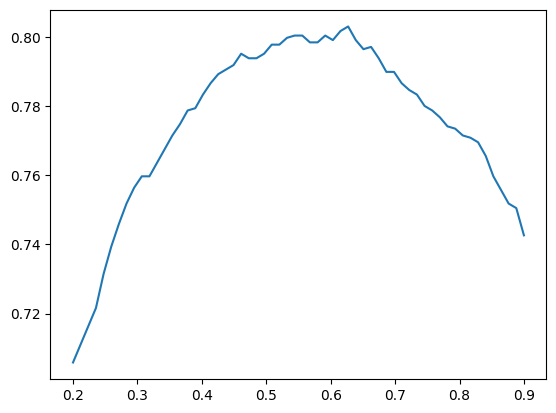

In [77]:
best_threshold = get_best_acc(sklearn_pipeline, valid_data, valid_target)

# Write results to a csv file

In [78]:
predictions_probs = sklearn_pipeline.predict_proba(test_df)[:,1]

In [79]:
#disaster_threshold = 0.5
disaster_threshold = best_threshold
predictions = [int(x > disaster_threshold) for x in predictions_probs]

In [80]:
sumbission = {"id": test_df['id'], "target": predictions}

In [81]:
submbission = pd.DataFrame.from_dict(sumbission)

In [82]:
submbission.to_csv("submission.csv", index=False)